# Logistic Regression Analysis

*Written by Jin Cheong & Luke Chang*

In this lab we are going to learn how to do more classifciation through logistic analysis. 

After the tutorial you will have the chance to apply the methods to a new set of data. 


## Introduction to logistic regression 

A logistic regression, also called a logit model, is used to model outcome variables that are binary. Examples of such variables are "hit versus miss," "success versus fail," or  "male or female." 

In the logit model, the log odds of the outcome is modeled as a linear combination of the predictor variables. 


Lets recall that the simple linear regression had the following form :
$y = \beta_0 + \beta_1\cdot x $

while the multiple linear regression had the following form : 
$y = \beta_0 + \beta_1x_1 + ... + \beta_nx_n$  

In logistic regression, instead of predicting the value of Y from Xs, we predict the *probability* of Y occurring given Xs. This is done by passing the model into a logistic (or sigmoid) function. Here is the simple form with one predictor variable.
# $P(Y) = \frac{1}{1 + e^{-(\beta_0 + \beta_1x_1)}}$

We can easily extend this to a n-predictors.


# $P(Y) = \frac{1}{1 + e^{-(\beta_0 + \beta_1x_1 + ... + \beta_nx_n)}}$



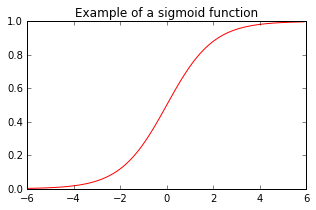

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
# Example of sigmoid function
plt.figure(figsize=(5,3))
def sigmoid(t):                          # Define the sigmoid function
    return (1/(1 + np.e**(-t)))    
plot_range = np.arange(-6, 6, 0.1)       
y_values = sigmoid(plot_range)
# Plot curve
plt.plot(plot_range,   # X-axis range
         y_values,          # Predicted values
         color="red")
plt.title("Example of a sigmoid function")

Now we will load our sample data and create a 'Alcabuse' variable to call it alcohol abuse if a student score more than 8 on drinking alcohol in a week. The dataset was retrieved from [here](http://archive.ics.uci.edu/ml/datasets/STUDENT+ALCOHOL+CONSUMPTION#) but it was modified to better illustrate our purpose.

In [6]:
# Load the data 
df = pd.read_csv('../Data/student-mat.csv')
df['Alcabuse']=0
df.loc[df['Dalc']+df['Walc'] >=8,'Alcabuse']=1 # Let's call it abuse if more than 8 alcohol consumption per week

We will test our hypothesis that a student is more likely to abuse alcohol if has more free time.

In [7]:
logm = smf.logit('Alcabuse ~ freetime',data=df).fit()
print logm.summary()

Optimization terminated successfully.
         Current function value: 0.337426
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               Alcabuse   No. Observations:                  395
Model:                          Logit   Df Residuals:                      393
Method:                           MLE   Df Model:                            1
Date:                Wed, 06 Apr 2016   Pseudo R-squ.:                  0.2522
Time:                        21:45:55   Log-Likelihood:                -133.28
converged:                       True   LL-Null:                       -178.24
                                        LLR p-value:                 2.489e-21
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -7.6262      0.857     -8.900      0.000        -9.306    -5.947
freetime       1.6416      0.

## Prediction

We ran our first logit model but we cannot interpret the coefficients as we did in the linear regression model because we applied a logit transform. There are two ways to interpret the results, in probability or odds. 

### Interpreting coefficients as probability

In [8]:
def invlogit(x):
    """Convert from log odds to probability"""
    """https://de.dariah.eu/tatom/classification_logistic_regression.html"""
    return 1/(1+np.exp(-x))

In [9]:
x = 5
palcabuse = invlogit(logm.params[0] + logm.params[1] * x)
print 'If a student\'s x was %i then he has %i percent probability of alcohol abuse' % (x,palcabuse*100)

If a student's x was 5 then he has 64 percent probability of alcohol abuse


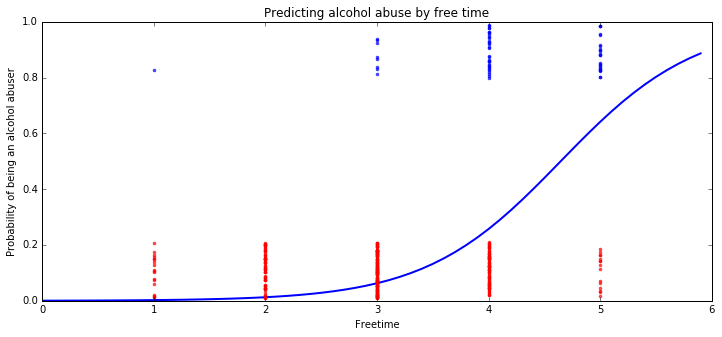

In [10]:
# Plot the model fits
xs =  np.arange(min(df.freetime)-1,max(df.freetime)+1,0.1)
ys = np.array([invlogit(logm.params[0] + logm.params[1] * x) for x in xs])
plt.figure(figsize=(12,5))
plt.plot(xs,ys,linewidth=2)
jitter = np.random.random(len(df.Alcabuse))/5
ys_outcomes = np.abs((df.Alcabuse==1)-0.01-jitter)
alpha = 0.7
plt.plot(df.freetime[df.Alcabuse == 1], ys_outcomes[df.Alcabuse ==1], 'b.', alpha=alpha)
plt.plot(df.freetime[df.Alcabuse == 0], ys_outcomes[df.Alcabuse ==0], 'r.', alpha=alpha)
plt.xlabel("Freetime")
plt.ylabel("Probability of being an alcohol abuser")
plt.title("Predicting alcohol abuse by free time")

### Interpreting coefficients as odds
In some cases, percents might not be an intuitive measure. Instead we might want to look at the odds of an event happening defined as:

# $odds = \frac{P(\text{event})}{P(\text{no event})}$
while $P(\text{event Y}) = \frac{1}{1 + e^{-(\beta_0 + \beta_1x_1)}}$

and $P(\text{no event Y}) = 1 - P(\text{event Y})$

If we want to look at how much the odds change for a unit increase in free time, we can use the following 

# $\triangle odds = \frac{\text{odds after a unit change in predictor}}{\text{original odds}} $

Unit increase in free time from 4 hours to 5 hours will increase the odds of being an alcoholic by how much? 

In [11]:
od1= invlogit(logm.params[0] + logm.params[1] * 5) / (1-invlogit(logm.params[0] + logm.params[1] * 5))
od2 = invlogit(logm.params[0] + logm.params[1] * 4) / (1-invlogit(logm.params[0] + logm.params[1] * 4))
dodds = od1/od2
print 'A student with 5hrs of free time compared to a student with 4 is %.2f times more likely to be an alcohol abuser' %dodds

A student with 5hrs of free time compared to a student with 4 is 5.16 times more likely to be an alcohol abuser


## Cross-validation 

The best way to see how well your model generalize is to train (or fit) your model on a training dataset then test it on a  separate test dataset. If you train and test your model on the same dataset (as we did above) you are likely to get a positvely biased result. The true generalizeability can only be observed when you git your model to a separate hold-out test sample that the model has not been exposed. This cross-validation method can easily be done by splitting the dataset before you begin your analysis. 

To split the data we will use the train_test_split function in the module sci-kit learn. 



In [12]:
from sklearn.cross_validation import train_test_split
np.random.seed(12345678)
train, test = train_test_split(df, train_size=0.6, random_state=1)

In [13]:
logmt = smf.logit('Alcabuse ~ freetime',data=train).fit()
print logmt.summary()

Optimization terminated successfully.
         Current function value: 0.314933
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               Alcabuse   No. Observations:                  237
Model:                          Logit   Df Residuals:                      235
Method:                           MLE   Df Model:                            1
Date:                Wed, 06 Apr 2016   Pseudo R-squ.:                  0.2730
Time:                        21:45:56   Log-Likelihood:                -74.639
converged:                       True   LL-Null:                       -102.66
                                        LLR p-value:                 7.074e-14
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -7.9420      1.135     -6.997      0.000       -10.167    -5.717
freetime       1.7073      0.

To assess the accuracy of the model you can look at the pseudo R-squared. 
Alternatively you an also calculate how well your predictions did to a certain cutoff. 
In our case, lets say that if the probability is larger than .5, they are considered a alcohol abuser. 
We will look the overall accuracy of the predictions along with its sensitivity and specificity as defined below.

Sensitivity : measures the proportion of positives that are correctly identified (e.g. we correctly identify the alcohol abusers)  
Specificity : measures the proportion of negatives that are correctly identified (e.g. we correctly identify the non-alcohol abusers)

In [14]:
ytestpred = logmt.predict(test)
ytestpred[ytestpred>=.5] =1 
ytestpred[ytestpred<.5] =0 
pd.crosstab(ytestpred,test["Alcabuse"])

Alcabuse,0,1
row_0,,
0.0,124,18
1.0,5,11


In [15]:
# Overall accuracy
print 'overall accuracy : %2f ' %((124+11)/float(test.shape[0]))
# Sensitivity and false negatives
print ''
print 'sensitivity : %2f ' %(11./(11+18))
print 'false negative : %2f ' %(18./(11+18))
# Specificity and false positives
print ''
print 'specificity : %2f ' %(124./(124+5))
print 'false positives : %2f ' %(5./(124+5))

overall accuracy : 0.854430 

sensitivity : 0.379310 
false negative : 0.620690 

specificity : 0.961240 
false positives : 0.038760 


# Regularization

When you have more features than observations, you face the problem of overfitting. That is you may end up with a model that is too specific that it doesn't generalize. In other cases, you might face the problem of feature selection. If you have numerous variables, it is time consuming to try every single combination of features in your model to see what yields the best result. Regularization attempts to solve this problem by introducting a loss function that penalizes the model for each additional features added to the model. The AIC / BIC values we mentioned in the first session is a form of regularization in comparing models. In this section we will look at Ridge and Lasso regressions that attempts to prevent overfitting in the model.

## Lasso regression
In short, Lasso is a feature selection method that reduces the number of features to use in a regression.  
This is useful if you have a lot of variables that are correlated or you have more variables than observations.  
Read more about Lasso [here](https://en.wikipedia.org/wiki/Lasso_(statistics).  
Also, [here](http://studentlife.cs.dartmouth.edu/smartgpa.pdf) is a study from Dartmouth that uses Lasso on the Student Life Dataset.

In our example, we will try to find which variables can predict the level of alcohol consumption. 

In [34]:
df['AlcSum']=df['Dalc']+df['Walc']

In [40]:
df.keys().values

array(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu',
       'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime',
       'studytime', 'failures', 'schoolsup', 'famsup', 'paid',
       'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1',
       'G2', 'G3', 'Alcabuse', 'AlcSum'], dtype=object)

In [117]:
from patsy import dmatrices
formula = 'AlcSum ~ school+sex+age+address+famsize+Pstatus+Medu+\
       Fedu+Mjob+Fjob+reason+guardian+traveltime+\
       studytime+failures+schoolsup+famsup+paid+activities+nursery+higher+\
       internet+romantic+famrel+freetime+goout+health+absences+G1+G2+G3'
y, X = dmatrices(formula_like=formula, data=df, return_type='dataframe')
m = smf.OLS(y,X)

In [218]:
# Ridge if L1_wt = 0 , Lasso if L1_wt = 1
regm = m.fit_regularized(method='coord_descent', maxiter=1000, alpha=0.2, L1_wt=1.0)
print regm.summary()

                            OLS Regression Results                            
Dep. Variable:                 AlcSum   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     3.571
Date:                Wed, 06 Apr 2016   Prob (F-statistic):           7.30e-11
Time:                        23:14:02   Log-Likelihood:                -855.37
No. Observations:                 395   AIC:                             1793.
Df Residuals:                     354   BIC:                             1956.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept                     0 

Use the Akaike information criterion (AIC), the Bayes Information criterion (BIC) and cross-validation to select an optimal value of the regularization parameter alpha of the Lasso estimator.For cross-validation, we use 20-fold with 2 algorithms to compute the Lasso path: coordinate descent, as implemented by the LassoCV class.
http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html

In [206]:
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
import time

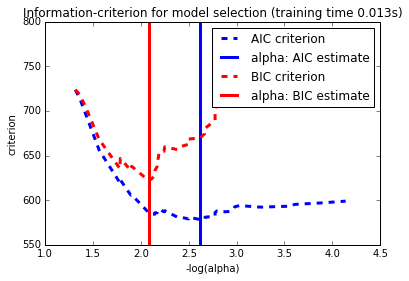

In [207]:
# LassoLarsIC: least angle regression with BIC/AIC criterion
model_bic = LassoLarsIC(criterion='bic')
t1 = time.time()
model_bic.fit(X, y)
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X, y)
alpha_aic_ = model_aic.alpha_


def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color,
             linewidth=3, label='%s criterion' % name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')

plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection (training time %.3fs)'
          % t_bic)

In [185]:

# LassoCV: coordinate descent
y, X = dmatrices(formula_like=formula, data=df, return_type='dataframe')
y = y.values.squeeze()
X = X.values
# Compute paths
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
model = LassoCV(cv=20).fit(X, y)
t_lasso_cv = time.time() - t1

# Display results
m_log_alphas = -np.log10(model.alphas_)

Computing regularization path using the coordinate descent lasso...


(0, 15)

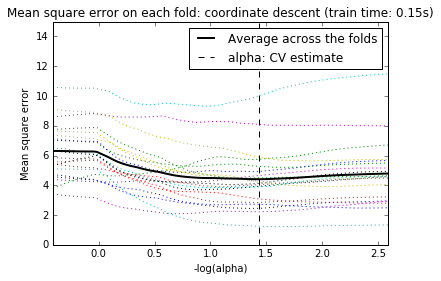

In [191]:
# Display results
m_log_alphas = -np.log10(model.alphas_)

plt.figure()
ymin, ymax = 0, 15;
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)

array([-0.40917512, -0.37887209, -0.34856906, -0.31826603, -0.287963  ,
       -0.25765997, -0.22735694, -0.19705391, -0.16675088, -0.13644785,
       -0.10614482, -0.07584179, -0.04553876, -0.01523573,  0.0150673 ,
        0.04537033,  0.07567336,  0.10597639,  0.13627942,  0.16658245,
        0.19688548,  0.22718851,  0.25749154,  0.28779457,  0.3180976 ,
        0.34840063,  0.37870366,  0.40900669,  0.43930972,  0.46961275,
        0.49991578,  0.53021881,  0.56052184,  0.59082488,  0.62112791,
        0.65143094,  0.68173397,  0.712037  ,  0.74234003,  0.77264306,
        0.80294609,  0.83324912,  0.86355215,  0.89385518,  0.92415821,
        0.95446124,  0.98476427,  1.0150673 ,  1.04537033,  1.07567336,
        1.10597639,  1.13627942,  1.16658245,  1.19688548,  1.22718851,
        1.25749154,  1.28779457,  1.3180976 ,  1.34840063,  1.37870366,
        1.40900669,  1.43930972,  1.46961275,  1.49991578,  1.53021881,
        1.56052184,  1.59082488,  1.62112791,  1.65143094,  1.68

## Ridge regression
The goal of the ridge function is to Choose λ for which the coefficients are not rapidly changing and have “sensible” signs

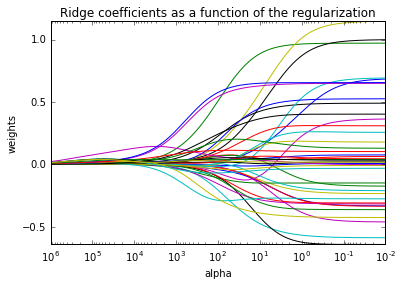

In [165]:
from sklearn import linear_model
y, X = dmatrices(formula_like=formula, data=df, return_type='dataframe')
y = y.values
X = X.values
n_alphas = 200
alphas = np.logspace(-2, 6, n_alphas)
clf = linear_model.Ridge(fit_intercept=False)

coefs = []
for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(X, y)
    coefs.append(clf.coef_)

###############################################################################
# Display results
ax = plt.gca()
ax.set_color_cycle(['b', 'r', 'g', 'c', 'k', 'y', 'm'])
ax.plot(alphas, np.squeeze(coefs))
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()